# Librarias

In [169]:
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sqlalchemy import select
from sqlalchemy import text
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
import sys
if '..' not in sys.path:
    sys.path.append('..')
from scripts import function as fn

# Credenciales


In [170]:
# Define tus credenciales locales aquí.
# Asegúrate de que las bases de datos 'gold' existan en tu MySQL ejecutando el notebook
DB_USER = "root"
DB_PASS = "juanMySQL0513." # Reemplaza con tu contraseña
DB_HOST = "localhost"
DB_PORT = "3306"

try:
    engine_gold = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/gold")
    print("Motores de base de datos configurados correctamente.")
except Exception as e:  
    print(f"Error al configurar los motores de base de datos: {e}")
    sys.exit(1)

Motores de base de datos configurados correctamente.


# k-means perfil de riesgo clientes no existentes


In [171]:
df=pd.read_sql_query("select*from risk_level_data",engine_gold)

In [172]:
df_original=df.copy()

## analisis de feautures

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FLAG_OWN_CAR         307511 non-null  object 
 1   FLAG_OWN_REALTY      307511 non-null  object 
 2   CNT_CHILDREN         307511 non-null  int64  
 3   AMT_INCOME_TOTAL     307511 non-null  float64
 4   AMT_CREDIT           307511 non-null  float64
 5   NAME_INCOME_TYPE     307511 non-null  object 
 6   NAME_EDUCATION_TYPE  307511 non-null  object 
 7   NAME_FAMILY_STATUS   307511 non-null  object 
 8   NAME_HOUSING_TYPE    307511 non-null  object 
 9   YEARS_BIRTH          307511 non-null  int64  
 10  DAYS_EMPLOYED        307511 non-null  int64  
 11  OWN_CAR_AGE          307511 non-null  object 
 12  OCCUPATION_TYPE      307511 non-null  object 
 13  TARGET               307511 non-null  int64  
dtypes: float64(2), int64(4), object(8)
memory usage: 32.8+ MB


In [174]:
df_int=df.select_dtypes(include=["number"])
df_int.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,YEARS_BIRTH,DAYS_EMPLOYED,TARGET
count,307511.000000,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000
mean,0.417052,1.687979e+05,5.990260e+05,43.435968,1954.848123,0.900365
std,0.722121,2.371231e+05,4.024908e+05,11.954593,2307.068896,0.336143
min,0.000000,2.565000e+04,4.500000e+04,20.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,34.000000,289.000000,1.000000
50%,0.000000,1.471500e+05,5.135310e+05,43.000000,1213.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,53.000000,2760.000000,1.000000
max,19.000000,1.170000e+08,4.050000e+06,69.000000,17912.000000,2.000000


In [175]:
colums_int=df_int.columns
colums_int

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'YEARS_BIRTH',
       'DAYS_EMPLOYED', 'TARGET'],
      dtype='object')

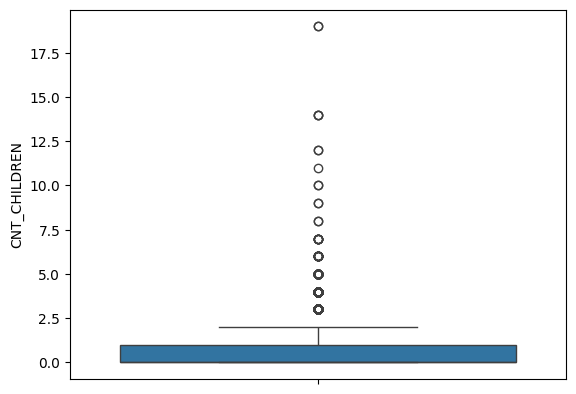

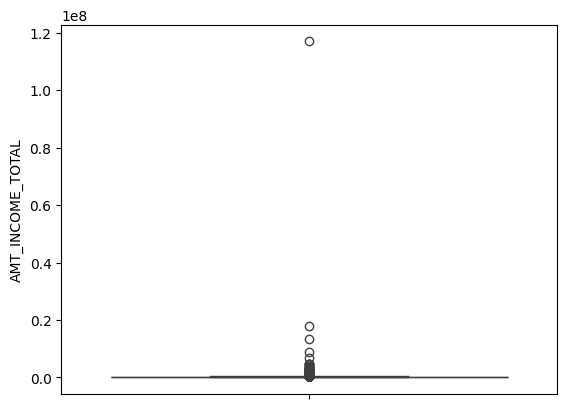

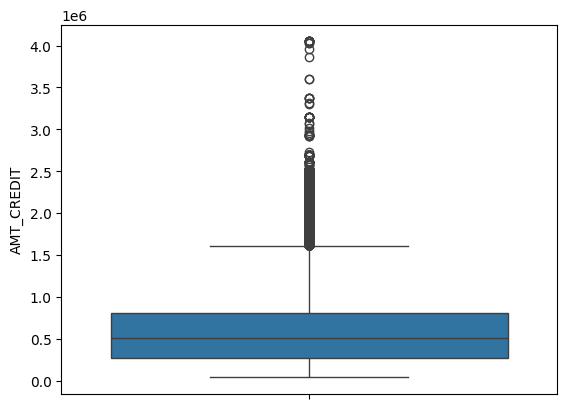

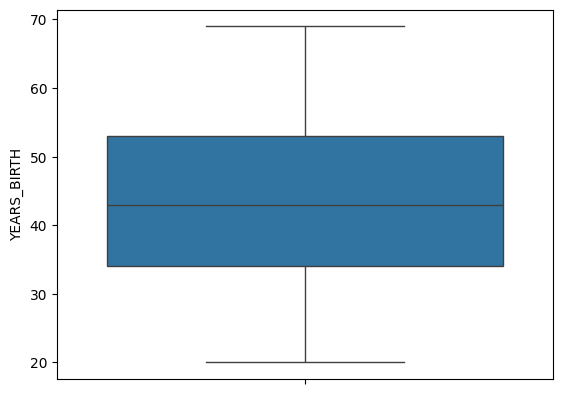

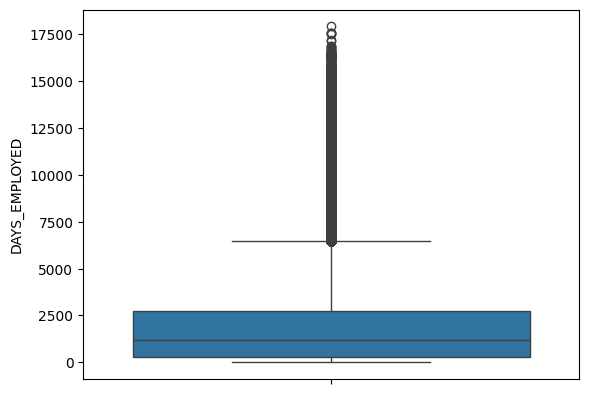

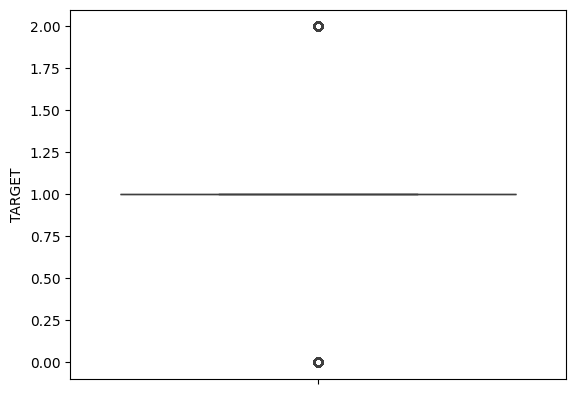

In [176]:
for colum in colums_int:
    sns.boxplot(df_int[colum])
    plt.show()

In [177]:
colums_ob=df.select_dtypes("object").columns

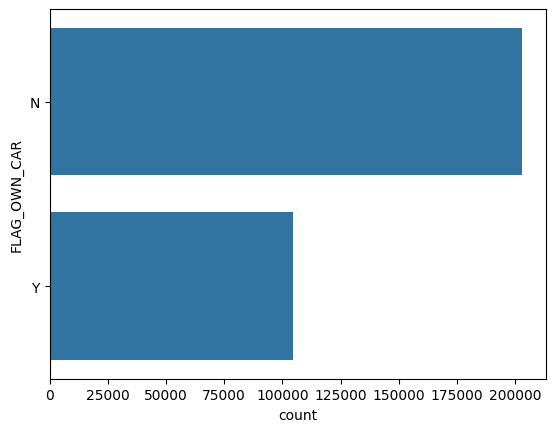

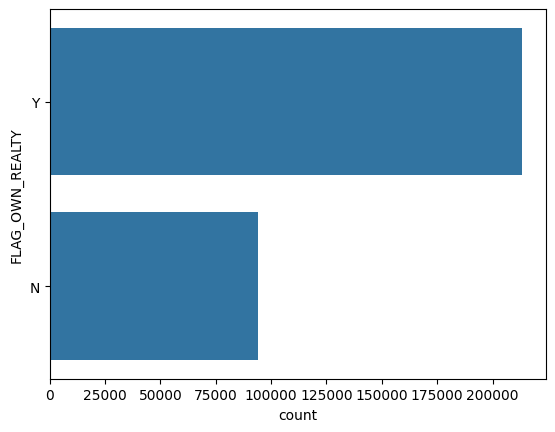

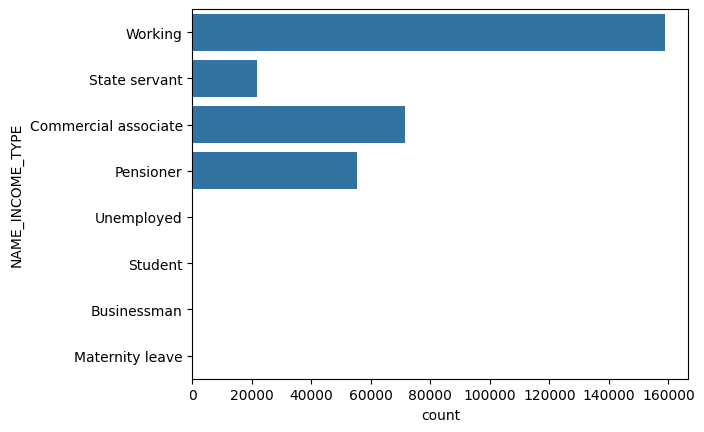

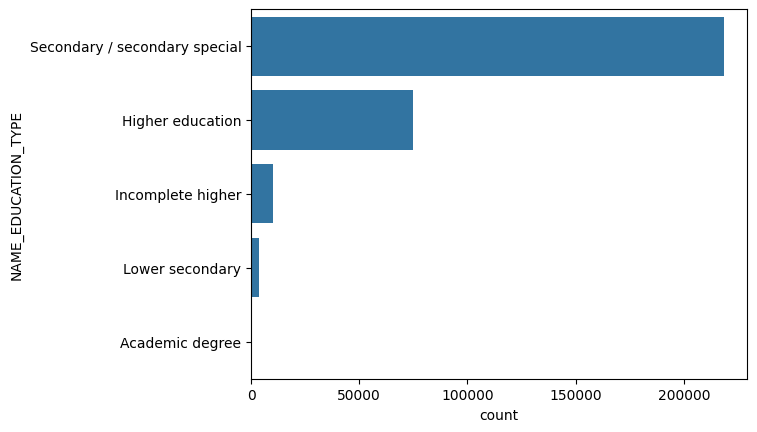

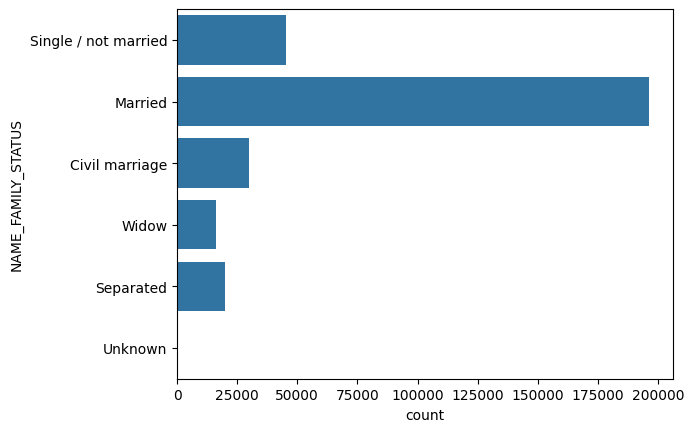

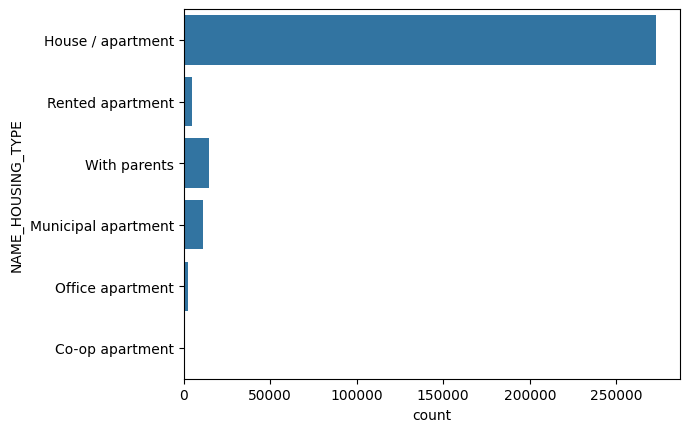

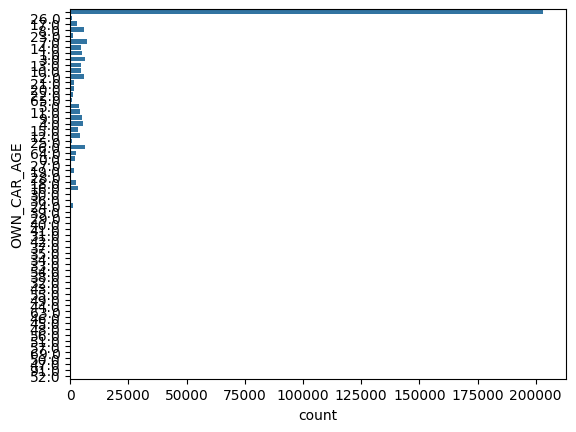

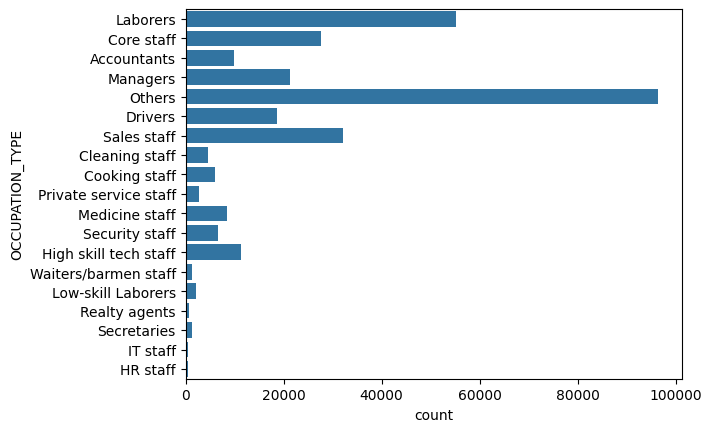

In [178]:
for colum in colums_ob:
    sns.countplot(y=colum, data=df)
    plt.show()

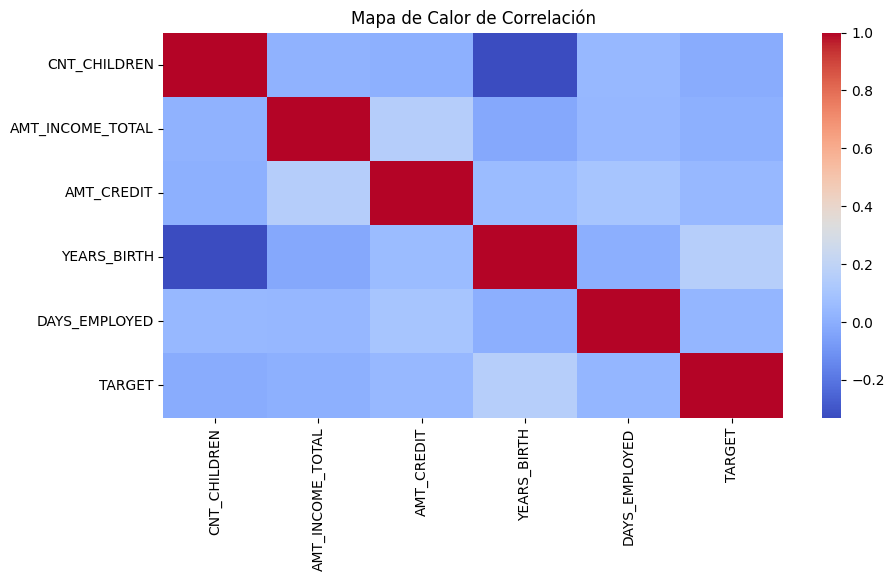

In [179]:
# Calcula la matriz de correlación
correlation_matrix = df_int.corr()

# Crea el mapa de calor
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') # annot=True si no tienes demasiadas variables
plt.title('Mapa de Calor de Correlación')
plt.show()

## transformacion de datos

In [180]:

for colum in colums_int:
    #Transformacion logaritmica
    df[colum] = np.log1p(df[colum])
    # Capping
    p1 = df[colum].quantile(0.01)
    p99 = df[colum].quantile(0.99)
    df[colum] = df[colum].clip(lower=p1, upper=p99)

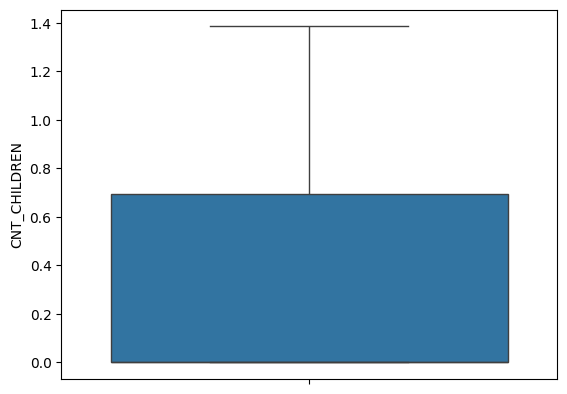

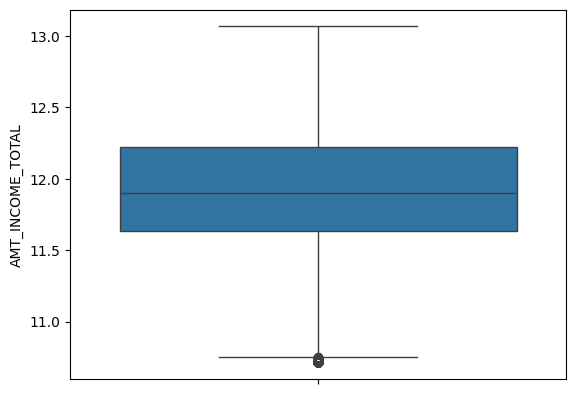

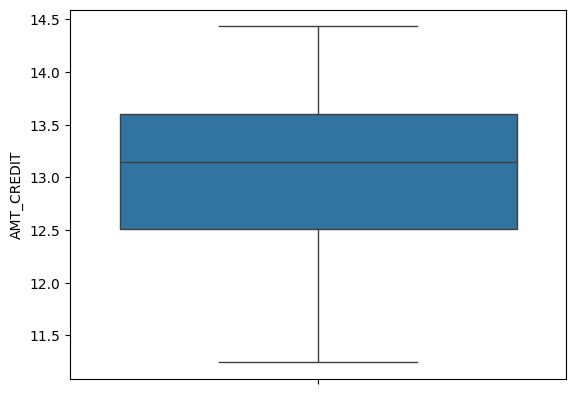

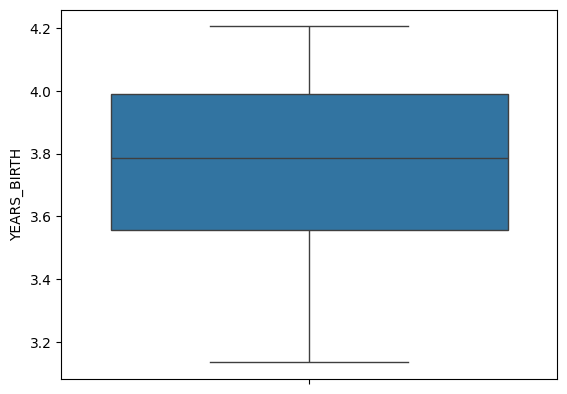

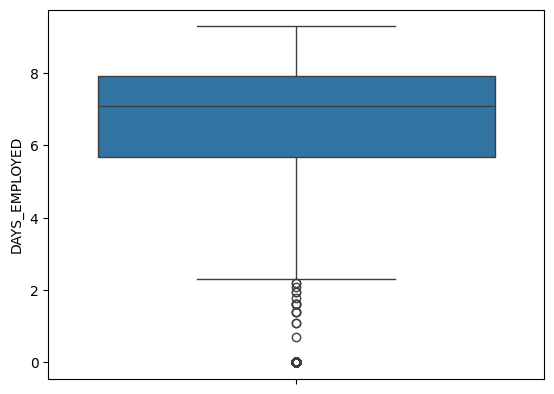

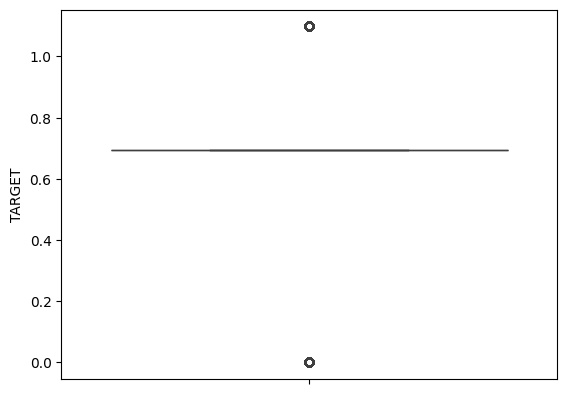

In [181]:
for colum in colums_int:
    sns.boxplot(df[colum])
    plt.show()

In [182]:
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace({
    'Unemployed': 'others',
    'Student': 'others',
    'Businessman': 'others',
    'Maternity leave': 'others'
})


In [183]:

# Calcular el umbral (1% del total de filas)
umbral = len(df) * 0.01

# Recorrer cada columna y reemplazar las categorías de baja frecuencia
for columna in colums_ob:
    # 1. Obtener frecuencias
    frecuencias = df[columna].value_counts()
    
    # 2. Detectar categorías menos frecuentes
    categorias_baja_frecuencia = frecuencias[frecuencias < umbral].index.tolist()
    
    # 3. Reemplazar por un nombre genérico
    df[columna] = df[columna].replace(categorias_baja_frecuencia, 'Less common')


In [184]:
df_train = pd.get_dummies(df, columns=colums_ob)
df_train=df_train.astype(int)

In [185]:
scaler=StandardScaler()
data_train=scaler.fit_transform(df_train)

In [186]:
df_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,YEARS_BIRTH,DAYS_EMPLOYED,TARGET,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Less common,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Others,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff
0,0,12,12,3,6,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,12,14,3,7,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,11,11,3,5,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,11,12,3,8,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,11,13,4,8,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,11,12,3,5,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
307507,0,11,12,4,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
307508,0,11,13,3,8,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
307509,0,12,12,3,8,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## model

In [187]:
k=KMeans(n_clusters=3,random_state=42)
k.fit(data_train)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [188]:
df_original["TARGET"]=k.labels_

In [189]:
df_original["TARGET"].value_counts()

TARGET
2    264502
0     32732
1     10277
Name: count, dtype: int64

In [190]:
df_original.to_sql("risk_level_data",engine_gold,if_exists="replace",schema="gold",index=False)

307511

In [191]:
df_original.drop("TARGET",axis=1).columns

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'YEARS_BIRTH',
       'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'OCCUPATION_TYPE'],
      dtype='object')

## Interpretacion de las clasificaciones

In [192]:
df_original.columns

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'YEARS_BIRTH',
       'DAYS_EMPLOYED', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'TARGET'],
      dtype='object')

In [193]:
# Iteramos sobre cada columna categórica para ver su distribución por clúster
for col in colums_ob:
    print(f"\n--- Distribución de '{col}' por Clúster ---")
    # value_counts(normalize=True) nos da las proporciones (porcentajes)
    # unstack() lo formatea en una tabla fácil de leer
    perfil_categorico = df_original.groupby('TARGET')[col].value_counts(normalize=True).unstack(fill_value=0)
    print(perfil_categorico)


--- Distribución de 'FLAG_OWN_CAR' por Clúster ---
FLAG_OWN_CAR         N         Y
TARGET                          
0             0.683490  0.316510
1             0.626934  0.373066
2             0.658252  0.341748

--- Distribución de 'FLAG_OWN_REALTY' por Clúster ---
FLAG_OWN_REALTY         N         Y
TARGET                             
0                0.592326  0.407674
1                0.361584  0.638416
2                0.268788  0.731212

--- Distribución de 'NAME_INCOME_TYPE' por Clúster ---
NAME_INCOME_TYPE  Businessman  Commercial associate  Maternity leave  \
TARGET                                                                 
0                    0.000000              0.253697         0.000000   
1                    0.000000              0.330836         0.000000   
2                    0.000038              0.226512         0.000019   

NAME_INCOME_TYPE  Pensioner  State servant   Student  Unemployed   Working  
TARGET                                                

In [194]:
# Creamos un diccionario para mapear el número del clúster a la etiqueta de riesgo
mapa_riesgo = {
    0: 'Riesgo Alto',
    1: 'Riesgo Medio',
    2: 'Riesgo Bajo'
}
df_original["TARGET"].replace(mapa_riesgo)


0         Riesgo Bajo
1         Riesgo Bajo
2         Riesgo Bajo
3         Riesgo Bajo
4         Riesgo Bajo
             ...     
307506    Riesgo Alto
307507    Riesgo Bajo
307508    Riesgo Bajo
307509    Riesgo Bajo
307510    Riesgo Bajo
Name: TARGET, Length: 307511, dtype: object

## Model clasificacion

In [195]:
df_original

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,YEARS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,TARGET
0,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,25,637,,Laborers,2
1,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,45,1188,,Core staff,2
2,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,52,225,26.0,Laborers,2
3,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,52,3039,,Laborers,2
4,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,54,3038,,Core staff,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,N,N,0,157500.0,254700.0,Working,Secondary / secondary special,Separated,With parents,25,236,,Sales staff,0
307507,N,Y,0,72000.0,269550.0,Pensioner,Secondary / secondary special,Widow,House / apartment,56,0,,Others,2
307508,N,Y,0,153000.0,677664.0,Working,Higher education,Separated,House / apartment,41,7921,,Managers,2
307509,N,Y,0,171000.0,370107.0,Commercial associate,Secondary / secondary special,Married,House / apartment,32,4786,,Laborers,2


In [196]:

prueba=df_original[colums_ob].columns.to_frame
prueba

<bound method Index.to_frame of Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OWN_CAR_AGE', 'OCCUPATION_TYPE'],
      dtype='object')>

In [197]:
categoricas=df_original.select_dtypes("object").columns

In [198]:
df_train=df_original.copy()

In [199]:
for colum in categoricas:
    freq_map = df_original[colum].value_counts().to_dict()
    df_train[colum] = df[colum].map(freq_map)

In [200]:
df_train = pd.get_dummies(df_original, columns=categoricas)
df_train=df_train.astype(int)

In [201]:
X=df_train.drop("TARGET",axis=1)
y=df_train["TARGET"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [202]:
model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [203]:
# 7. Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6661
           1       1.00      1.00      1.00      2066
           2       1.00      1.00      1.00     52776

    accuracy                           1.00     61503
   macro avg       1.00      1.00      1.00     61503
weighted avg       1.00      1.00      1.00     61503



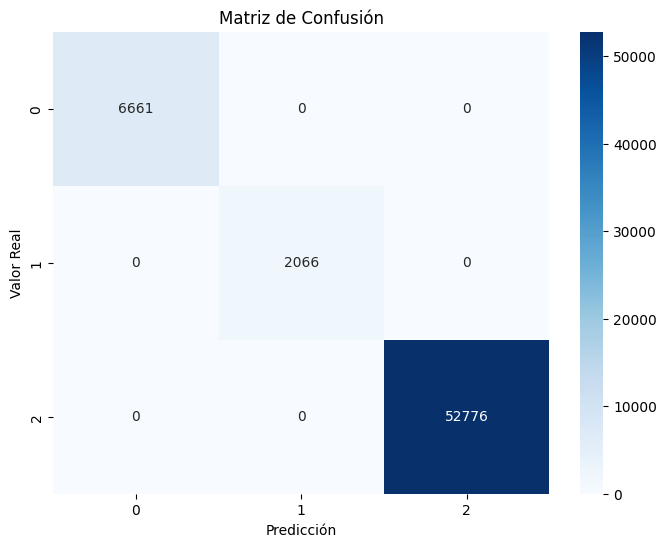

In [204]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

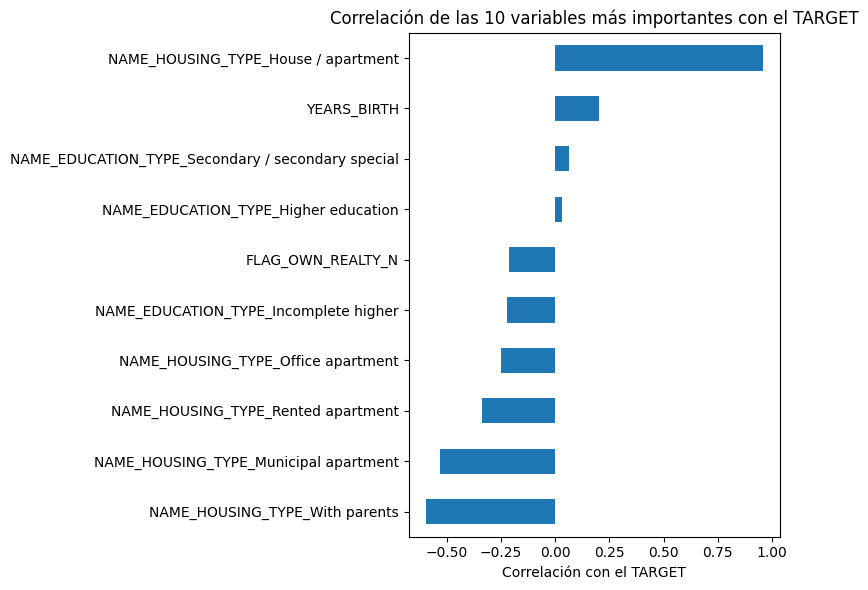

In [205]:
# 1. Importancia de características
importances = model.feature_importances_
features = X.columns

# 2. Crear DataFrame de importancias
feat_importance = pd.DataFrame({
    "feature": features,
    "importance": importances
})

# 3. Seleccionar las 10 más importantes
top_features = feat_importance.sort_values(by="importance", ascending=False).head(10)

# 4. Extraer esas columnas del dataset original
top_vars = top_features["feature"].tolist()
df_top = df_train[top_vars + ["TARGET"]]  # Asegúrate de poner el nombre real

# 5. Codificar TARGET si no es numérico
if df_top["TARGET"].dtype == "object":
    df_top["TARGET"] = df_top["TARGET"].astype("category").cat.codes

# 6. Calcular correlación con el TARGET
correlations = df_top.corr(numeric_only=True)["TARGET"].drop("TARGET")

# 7. Mostrar en gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
correlations.sort_values().plot(kind="barh")
plt.xlabel("Correlación con el TARGET")
plt.title("Correlación de las 10 variables más importantes con el TARGET")
plt.tight_layout()
plt.show()


# k-means perfil de riesgo clientes existentes


In [206]:
df_model_4ID = pd.read_sql_query("select *from model_gold_id",engine_gold)
df_model_4ID.head()

,SK_ID_CURR,HAS_CREDIT_BALANCE,HAS_LATE_PAYMENTS,HAS_ADDITIONAL_CHARGES,NUM_LOANS_TOTAL,AVG_PAYMENT_RATIO,FRAC_PAYMENTS_LATE,AVG_DELAY_DAYS,MAX_DELAY_DAYS,FRAC_MISSED_PAYMENTS,...,BUREAU_TYPE_CASH_LOAN_(NON-EARMARKED),BUREAU_TYPE_CONSUMER_CREDIT,BUREAU_TYPE_CREDIT_CARD,BUREAU_TYPE_INTERBANK_CREDIT,BUREAU_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT,BUREAU_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT,BUREAU_TYPE_MICROLOAN,BUREAU_TYPE_MORTGAGE,BUREAU_TYPE_UNKNOWN_TYPE_OF_LOAN,TARGET
0,100006,0,0,0,16.0,1.000000,0.000000,0.000000,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,100011,1,0,0,130.0,0.907692,0.146154,54.368421,958.0,0.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,100013,1,0,0,155.0,0.935484,0.070968,7.636364,21.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,100021,0,0,0,23.0,1.000000,0.173913,14.000000,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,100023,0,0,0,26.0,1.000000,0.000000,0.000000,0.0,0.0,...,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [207]:
df_model_4ID_copy = df_model_4ID.copy()

### Preparación de la data 

In [208]:
df_model_4ID_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103558 entries, 0 to 103557
Data columns (total 38 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   SK_ID_CURR                                          103558 non-null  int64  
 1   HAS_CREDIT_BALANCE                                  103558 non-null  int64  
 2   HAS_LATE_PAYMENTS                                   103558 non-null  int64  
 3   HAS_ADDITIONAL_CHARGES                              103558 non-null  int64  
 4   NUM_LOANS_TOTAL                                     103558 non-null  float64
 5   AVG_PAYMENT_RATIO                                   103558 non-null  float64
 6   FRAC_PAYMENTS_LATE                                  103558 non-null  float64
 7   AVG_DELAY_DAYS                                      103558 non-null  float64
 8   MAX_DELAY_DAYS                                      103558 non-n

In [209]:
cat_cols = df_model_4ID_copy.select_dtypes(include='object').columns

In [210]:
umbral = len(df_model_4ID_copy) * 0.01

for col in cat_cols:
    frecuencias = df_model_4ID_copy[col].value_counts()
    categorias_raras = frecuencias[frecuencias < umbral].index
    df_model_4ID_copy[col] = df_model_4ID_copy[col].replace(categorias_raras, 'Less common')

In [211]:
df_encoded = pd.get_dummies(df_model_4ID_copy, columns=cat_cols, prefix_sep='_')

In [212]:
# pasas los bool a int
bool_cols = df_encoded.select_dtypes(include='bool').columns
for col in bool_cols:
    df_encoded[col] = df_encoded[col].astype(int)

In [213]:
scaler_id = StandardScaler()
data_scaled = scaler_id.fit_transform(df_encoded)

In [214]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

In [215]:
df_model_4ID['TARGET'] = clusters
print(df_model_4ID['TARGET'].value_counts())
df_model_4ID.head()

TARGET
1    50917
2    35621
0    17020
Name: count, dtype: int64


,SK_ID_CURR,HAS_CREDIT_BALANCE,HAS_LATE_PAYMENTS,HAS_ADDITIONAL_CHARGES,NUM_LOANS_TOTAL,AVG_PAYMENT_RATIO,FRAC_PAYMENTS_LATE,AVG_DELAY_DAYS,MAX_DELAY_DAYS,FRAC_MISSED_PAYMENTS,...,BUREAU_TYPE_CASH_LOAN_(NON-EARMARKED),BUREAU_TYPE_CONSUMER_CREDIT,BUREAU_TYPE_CREDIT_CARD,BUREAU_TYPE_INTERBANK_CREDIT,BUREAU_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT,BUREAU_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT,BUREAU_TYPE_MICROLOAN,BUREAU_TYPE_MORTGAGE,BUREAU_TYPE_UNKNOWN_TYPE_OF_LOAN,TARGET
0,100006,0,0,0,16.0,1.000000,0.000000,0.000000,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,100011,1,0,0,130.0,0.907692,0.146154,54.368421,958.0,0.0,...,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,100013,1,0,0,155.0,0.935484,0.070968,7.636364,21.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,100021,0,0,0,23.0,1.000000,0.173913,14.000000,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,100023,0,0,0,26.0,1.000000,0.000000,0.000000,0.0,0.0,...,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [216]:
df_analisis_clusters = df_model_4ID.copy()
perfil_clusters = df_analisis_clusters.groupby('TARGET').mean(numeric_only=True)

# Mostramos la tabla de perfiles
display(perfil_clusters)

,SK_ID_CURR,HAS_CREDIT_BALANCE,HAS_LATE_PAYMENTS,HAS_ADDITIONAL_CHARGES,NUM_LOANS_TOTAL,AVG_PAYMENT_RATIO,FRAC_PAYMENTS_LATE,AVG_DELAY_DAYS,MAX_DELAY_DAYS,FRAC_MISSED_PAYMENTS,...,BUREAU_TYPE_CAR_LOAN,BUREAU_TYPE_CASH_LOAN_(NON-EARMARKED),BUREAU_TYPE_CONSUMER_CREDIT,BUREAU_TYPE_CREDIT_CARD,BUREAU_TYPE_INTERBANK_CREDIT,BUREAU_TYPE_LOAN_FOR_BUSINESS_DEVELOPMENT,BUREAU_TYPE_LOAN_FOR_WORKING_CAPITAL_REPLENISHMENT,BUREAU_TYPE_MICROLOAN,BUREAU_TYPE_MORTGAGE,BUREAU_TYPE_UNKNOWN_TYPE_OF_LOAN
TARGET,,,,,,,,,,,,,,,,,,,,,
0,277477.448942,0.223561,0.0,0.041481,83.963337,1.447130,0.065038,14.907564,38.088602,0.000425,...,0.005934,0.000118,7.077556,2.119095,0.00000,0.002938,0.001293,0.141951,0.000470,0.004407
1,278083.113911,0.106212,0.0,0.024432,51.223481,1.163647,0.062081,15.070111,34.566962,0.000689,...,0.001336,0.000000,1.515388,0.382819,0.00002,0.001532,0.000079,0.012118,0.000079,0.000373
2,279239.856573,0.184386,0.0,0.038460,98.943067,1.586949,0.068678,7.951092,23.795009,0.000235,...,0.001684,0.000000,1.785464,0.544566,0.00000,0.001572,0.000197,0.015075,0.000056,0.000842


`Conclusión del Análisis de Clústeres y Etiquetado de Riesgo`


Una vez ejecutado el algoritmo de clustering K-Means sobre el perfil financiero consolidado de los clientes existentes, se identificaron tres grupos distintos y estadísticamente significativos. El análisis posterior del comportamiento promedio de cada clúster nos permitió asignarles una etiqueta de riesgo de negocio clara y accionable.

A continuación, se detalla la interpretación de cada segmento:


`Clúster 2: Riesgo Bajo (Clientes Activos y Resilientes)`

Este segmento, a pesar de tener la **frecuencia más alta de pagos tardíos** (`FRAC_PAYMENTS_LATE` = 0.068), demuestra ser el de menor riesgo. La clave de esta aparente contradicción reside en la **severidad de dichos atrasos**: con un promedio de solo **7.95 días** (`AVG_DELAY_DAYS`), sus retrasos son significativamente más cortos que los de cualquier otro grupo. Se trata de "micro-atrasos" que no escalan a impagos graves.

**Características Clave:**
- **Muy Activos:** Tienen la mayor actividad de pagos (`NUM_LOANS_TOTAL` = 98.9), lo que indica una relación recurrente y de alto volumen con la entidad.
- **Baja Tasa de Impago:** Presentan la menor proporción de pagos completamente omitidos (`FRAC_MISSED_PAYMENTS`), demostrando una alta fiabilidad para cumplir finalmente con sus obligaciones.
- **Bajo Endeudamiento Externo:** Su perfil en el bureau de crédito es conservador.

**Conclusión de Negocio:** Este es el **perfil de cliente ideal**. Son clientes experimentados que utilizan activamente los productos crediticios y, aunque a veces gestionan sus pagos al límite de las fechas, demuestran una alta capacidad para recuperarse y evitar el impago real. Son un objetivo principal para campañas de fidelización y venta cruzada.

---

`Clúster 1: Riesgo Medio (Clientes Inexpertos o Frágiles)`

Este clúster representa un segmento intermedio. Aunque su **frecuencia de atrasos es la más baja** (`FRAC_PAYMENTS_LATE` = 0.062), la **severidad y las consecuencias de sus fallos son las más altas**. Su promedio de días de retraso (`AVG_DELAY_DAYS` = 15.07) y, más importante aún, su **proporción de pagos omitidos** (`FRAC_MISSED_PAYMENTS` = 0.000689) son las peores del conjunto.

**Características Clave:**
- **Menos Experimentados:** Muestran la menor actividad de pagos (`NUM_LOANS_TOTAL` = 51.2) y el menor número de créditos externos.
- **Impacto Severo:** Cuando fallan, el impacto es mayor, lo que sugiere una menor capacidad de recuperación financiera.

**Conclusión de Negocio:** Este grupo representa a clientes que, aunque no problemáticos de forma recurrente, son **financieramente más frágiles**. Un evento inesperado puede llevarlos a un impago significativo. Requieren un monitoreo más cercano, especialmente en las primeras etapas de un nuevo crédito, y podrían beneficiarse de programas de educación financiera.

---

`Clúster 0: Riesgo Alto (Clientes Sobreendeudados)`

La principal señal de alarma para este segmento no proviene de su comportamiento con Home Credit (que es intermedio), sino de su **perfil de endeudamiento externo**. Con un promedio de **7.07 créditos de consumo** y **2.11 tarjetas de crédito** en otras entidades (`BUREAU_TYPE_*`), su carga financiera total es drásticamente superior a la de los otros grupos.

**Características Clave:**
- **Alto Endeudamiento Externo:** Manejan un volumen de deuda con terceros que multiplica por 3 o 4 al de los otros segmentos.
- **Riesgo Sistémico:** Son los más vulnerables a un "efecto dominó". Un problema con cualquiera de sus múltiples acreedores podría desencadenar un impago en cascada.

**Conclusión de Negocio:** Este es el **segmento de mayor riesgo** a pesar de que su historial interno no sea el peor. La alta carga de deuda externa los hace impredecibles y altamente vulnerables a shocks económicos. Las decisiones de crédito para este grupo deben ser extremadamente cautelosas, requiriendo una evaluación exhaustiva de su capacidad de pago global antes de aprobar nuevas solicitudes.

In [217]:
df_model_4ID.to_sql("model_gold_id",engine_gold,if_exists="replace",schema="gold",index=False)

103558

# Modelo de clasifiación RandomForest

In [218]:
df_para_entrenamiento = df_model_4ID.copy()

X_ID = df_para_entrenamiento.drop(columns=['SK_ID_CURR', 'TARGET'])

y_ID = df_para_entrenamiento['TARGET']

# Como la tabla Gold ya es legible, necesitamos hacer One-Hot Encoding en las columnas categóricas
categorical_features = X_ID.select_dtypes(include=['object']).columns
X_ID_encoded = pd.get_dummies(X_ID, columns=categorical_features, prefix_sep='_')
bool_cols = X_ID_encoded.select_dtypes(include='bool').columns
X_ID_encoded = X_ID_encoded.astype(int)

print("Forma de las características (X_ID):", X_ID_encoded.shape)
print("Forma del objetivo (y):", y_ID.shape)

Forma de las características (X_ID): (103558, 44)
Forma del objetivo (y): (103558,)


In [220]:
X_scaled = scaler_id.fit_transform(X_ID_encoded)
X_train_ID, X_test_ID, y_train_ID, y_test_ID = train_test_split(X_scaled, y_ID, test_size=0.2, random_state=42)
model_ID = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
model_ID.fit(X_train_ID, y_train_ID)
y_pred_ID = model_ID.predict(X_test_ID)

In [221]:
print("Accuracy:", accuracy_score(y_test_ID, y_pred_ID))

Accuracy: 0.9715623792970258


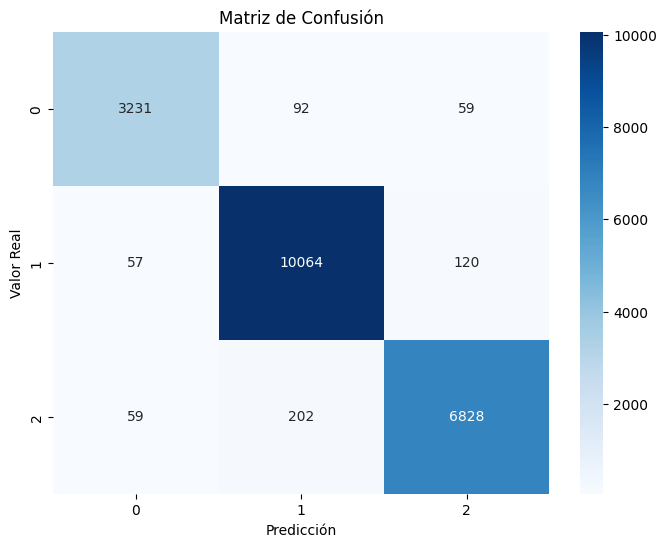

In [222]:
cm_ID = confusion_matrix(y_test_ID, y_pred_ID)
plt.figure(figsize=(8,6))
sns.heatmap(cm_ID, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

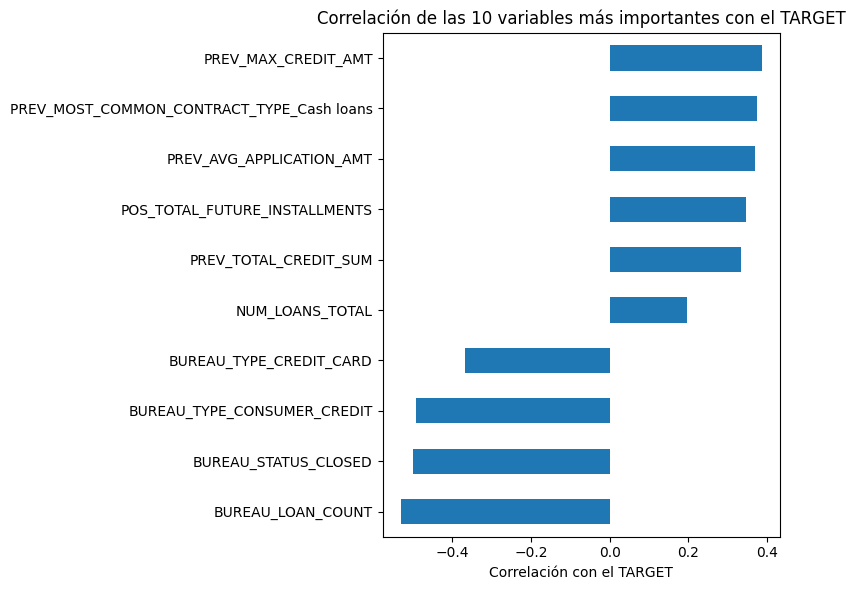

In [224]:
importances = model_ID.feature_importances_
features = X_ID_encoded.columns

feat_importance_ID = pd.DataFrame({
    "feature": features,
    "importance": importances
})

top_features_ID = feat_importance_ID.sort_values(by="importance", ascending=False).head(10)

top_vars_ID = top_features_ID["feature"].tolist()
df_top_corr_ID = X_ID_encoded[top_vars_ID].copy()
df_top_corr_ID['TARGET'] = y_ID.values
correlations_ID = df_top_corr_ID.corr(numeric_only=True)["TARGET"].drop("TARGET")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
correlations_ID.sort_values().plot(kind="barh")
plt.xlabel("Correlación con el TARGET")
plt.title("Correlación de las 10 variables más importantes con el TARGET")
plt.tight_layout()
plt.show()

`Resumen de Conclusiones del Gráfico de Correlación`

El análisis de correlación entre las 10 características más importantes y el nivel de riesgo (`TARGET`) revela patrones claros sobre los perfiles de los clientes:

**Factores Asociados a un Mayor Riesgo (Correlación Positiva)**

1.  **Alto Endeudamiento Histórico:** Las variables `PREV_MAX_CREDIT_AMT` y `PREV_AVG_APPLICATION_AMT` son los indicadores más fuertes de alto riesgo. Los clientes que han solicitado y manejado montos de crédito elevados en el pasado tienden a ser clasificados en clústeres más riesgosos.

2.  **Preferencia por Préstamos de Consumo:** Una alta frecuencia de `Cash loans` como tipo de contrato anterior (`PREV_MOST_COMMON_CONTRACT_TYPE_Cash loans`) se correlaciona positivamente con un mayor riesgo, posiblemente indicando una necesidad recurrente de liquidez.

3.  **Carga de Deuda Futura:** Un mayor número de cuotas pendientes de pago (`POS_TOTAL_FUTURE_INSTALLMENTS`) también está ligado a un mayor riesgo, reflejando un compromiso financiero que limita la capacidad de pago futura.

**Factores Asociados a un Menor Riesgo (Correlación Negativa)**

1.  **Experiencia Crediticia Externa (Bureau):** Este es el factor más significativo para predecir un bajo riesgo. Las variables `BUREAU_LOAN_COUNT`, `BUREAU_TYPE_CONSUMER_CREDIT`, y `BUREAU_TYPE_CREDIT_CARD` tienen una fuerte correlación negativa. Esto sugiere que los clientes con un historial crediticio más amplio y diversificado con otras instituciones son considerados más fiables.

2.  **Historial de Pagos Exitosos:** La variable `BUREAU_STATUS_CLOSED` (número de créditos cerrados en el bureau) también se asocia fuertemente con un menor riesgo. Demuestra que el cliente tiene un historial comprobado de cumplir con sus obligaciones financieras hasta el final.

---
**En síntesis, el modelo ha aprendido a diferenciar entre:**
-   Un **perfil riesgoso**, caracterizado por un alto endeudamiento histórico interno.
-   Un **perfil seguro**, caracterizado por una amplia y exitosa experiencia en el sistema financiero externo.